In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torch

In [2]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
train_dir = '/opt/ml/input/data/train'
test_dir = '/opt/ml/input/data/test'

In [3]:
csv_path = os.path.join(train_dir, 'train.csv')
csv = pd.read_csv(csv_path)
image_dir = os.path.join(train_dir, 'images')
new_image_dir = os.path.join(train_dir, 'face_images')
if not os.path.exists(new_image_dir):
        os.mkdir(new_image_dir)
        
pathlist = csv['path']

image_path = []
new_image_path = []
for p in pathlist:
    # 현재 경로
    images = [os.path.join(*[image_dir, p, image]) for image in os.listdir(os.path.join(image_dir, p)) if not image[:1] == '.']
    
    # 저장될 경로
    new_images = [os.path.join(*[new_image_dir, p, image]) for image in os.listdir(os.path.join(image_dir, p)) if not image[:1] == '.']
    folder = os.path.join(new_image_dir, p)
    if not os.path.exists(folder):
        os.mkdir(folder)
    
    for image in images:
        image_path.append(image)
    for new_image in new_images:
        new_image_path.append(new_image)
        

In [4]:
from facenet_pytorch import MTCNN

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

def faceCrop(img, output_img_size : tuple = (350,350)): 
    '''
        image의 얼굴부분만 Crop 하는 함수
        img(ndarray) : cv2.imread와 cv2.cvtColor(,cv2.COLOR_BGR2RGB)의 결과값 입력
        output_img_size : output으로 받고싶은 image size 입력
    '''
    try:
        boxes,probs = mtcnn.detect(img) # MTCNN을 활용하여 img내에서 얼굴을 찾음
    except:
        return img
    # 찾은 경우 -> boxes : 좌표값, probs : 확률값 출력
    # 못찾은 경우 -> boxes : None, probs : [None] 출력
    
    if probs[0] == None: # 못찾은 경우, image center 값 출력
#         print("Not Found")
        return img_center_crop(img, output_img_size)
    
    else :  # 찾은 경우, 얼굴 center기준으로 outputsize를 계산하여 출력
        xmid = int((boxes[0, 0]+boxes[0, 2])/2)
        ymid = int((boxes[0, 1]+boxes[0, 3])/2)
        
        xmin = xmid - output_img_size[0]//2
        ymin = ymid - output_img_size[1]//2
        xmax = xmid + output_img_size[0] - output_img_size[0]//2
        ymax = ymid + output_img_size[1] - output_img_size[1]//2
        
        if any((xmax < 0,xmax > img.shape[1],ymax < 0,ymax > img.shape[0])): # 찾은 후 box가 image 사이즈보다 클려
            return img_center_crop(img, output_img_size)
        
        else :  # 
            new_img = img[ymin:ymax, xmin:xmax, :]
            if new_img.shape[0] == 0 or new_img.shape[1]==0:
                return img
            else:
                return new_img

def img_center_crop(img, output_img_size : tuple = (350,350)): 
    ximg_cen = int((img.shape[1])/2)
    yimg_cen = int((img.shape[0])/2)

    xmin = ximg_cen - output_img_size[0]//2
    ymin = yimg_cen - output_img_size[1]//2
    xmax = ximg_cen + output_img_size[0] - output_img_size[0]//2
    ymax = yimg_cen + output_img_size[1] - output_img_size[1]//2   
    
    new_img = img[ymin:ymax, xmin:xmax, :]
    
    return new_img

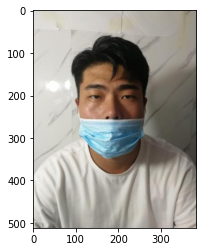

In [6]:
test = image_path[3386]
# print(image_path[])
image = cv2.imread(test)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

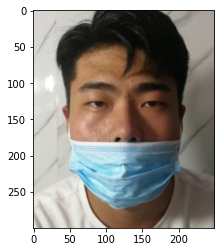

In [7]:
output_size = (250,300)
image = faceCrop(image,output_size)
plt.imshow(image)
# image

In [9]:
from tqdm import tqdm

output_size = (250,300)
total = len(image_path)
assert (len(image_path) == len(new_image_path))
for i, (original, new) in tqdm(enumerate(zip(image_path, new_image_path)), total=total):
    image = cv2.imread(original)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_after = faceCrop(image,output_size)
    image_after = cv2.cvtColor(image_after, cv2.COLOR_RGB2BGR)
#     print(new)
    cv2.imwrite(new, image_after)

100%|██████████| 18900/18900 [13:32<00:00, 23.26it/s] 


## Eval data

In [10]:
test_dir = '/opt/ml/input/data/eval'
csv_path = os.path.join(test_dir, 'info.csv')
csv = pd.read_csv(csv_path)['ImageID']

image_dir = os.path.join(test_dir, 'images')
new_image_dir = os.path.join(test_dir, 'new_images')
if not os.path.exists(new_image_dir):
        os.mkdir(new_image_dir)

image_path = []
new_image_path = []

for image in csv:
    image_path.append(os.path.join(image_dir, image))
    new_image_path.append(os.path.join(new_image_dir, image))

total = len(image_path)

for i, (original, new) in tqdm(enumerate(zip(image_path, new_image_path)), total=total):
    image = cv2.imread(original)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_after = faceCrop(image,output_size)
    image_after = cv2.cvtColor(image_after, cv2.COLOR_RGB2BGR)
#     print(new)
    cv2.imwrite(new, image_after)

100%|██████████| 12600/12600 [08:44<00:00, 24.01it/s]
